# Robust Linear Models

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.sandbox.regression.predstd import wls_prediction_std

## Estimation

Load data:

In [3]:
data = sm.datasets.stackloss.load()
data.exog = sm.add_constant(data.exog)

/home/jq/local/opt/miniconda3/lib/python3.7/site-packages/statsmodels/datasets/utils.py:100: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exog = np.column_stack(data[field] for field in exog_name)


Huber's T norm with the (default) median absolute deviation scaling

In [4]:
huber_t = sm.RLM(data.endog, data.exog, M=sm.robust.norms.HuberT())
hub_results = huber_t.fit()
print(hub_results.params)
print(hub_results.bse)
print(hub_results.summary(yname='y',
            xname=['var_%d' % i for i in range(len(hub_results.params))]))

[-41.02649835   0.82938433   0.92606597  -0.12784672]
[9.79189854 0.11100521 0.30293016 0.12864961]
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                   21
Model:                            RLM   Df Residuals:                       17
Method:                          IRLS   Df Model:                            3
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Wed, 05 Jun 2019                                         
Time:                        10:11:35                                         
No. Iterations:                    19                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------

Huber's T norm with 'H2' covariance matrix

In [5]:
hub_results2 = huber_t.fit(cov="H2")
print(hub_results2.params)
print(hub_results2.bse)

[-41.02649835   0.82938433   0.92606597  -0.12784672]
[9.08950419 0.11945975 0.32235497 0.11796313]


Andrew's Wave norm with Huber's Proposal 2 scaling and 'H3' covariance matrix

In [6]:
andrew_mod = sm.RLM(data.endog, data.exog, M=sm.robust.norms.AndrewWave())
andrew_results = andrew_mod.fit(scale_est=sm.robust.scale.HuberScale(), cov="H3")
print('Parameters: ', andrew_results.params)

Parameters:  [-40.8817957    0.79276138   1.04857556  -0.13360865]


See ``help(sm.RLM.fit)`` for more options and ``module sm.robust.scale`` for scale options

## Comparing OLS and RLM

Artificial data with outliers:

In [7]:
nsample = 50
x1 = np.linspace(0, 20, nsample)
X = np.column_stack((x1, (x1-5)**2))
X = sm.add_constant(X)
sig = 0.3   # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta)
y2 = y_true2 + sig*1. * np.random.normal(size=nsample)
y2[[39,41,43,45,48]] -= 5   # add some outliers (10% of nsample)

### Example 1: quadratic function with linear truth

Note that the quadratic term in OLS regression will capture outlier effects. 

In [8]:
res = sm.OLS(y2, X).fit()
print(res.params)
print(res.bse)
print(res.predict())

[ 5.16584172  0.49688537 -0.01103389]
[0.46027103 0.07105963 0.00628768]
[ 4.88999451  5.13600293  5.37833492  5.61699048  5.85196961  6.0832723
  6.31089857  6.53484841  6.75512181  6.97171878  7.18463933  7.39388344
  7.59945112  7.80134237  7.99955719  8.19409557  8.38495753  8.57214305
  8.75565215  8.93548481  9.11164104  9.28412084  9.45292421  9.61805115
  9.77950166  9.93727574 10.09137338 10.2417946  10.38853938 10.53160774
 10.67099966 10.80671515 10.93875421 11.06711684 11.19180303 11.3128128
 11.43014614 11.54380304 11.65378351 11.76008756 11.86271517 11.96166635
 12.0569411  12.14853942 12.2364613  12.32070676 12.40127578 12.47816838
 12.55138454 12.62092427]


Estimate RLM:

In [9]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)
print(resrlm.bse)

[ 5.11612653e+00  4.81764254e-01 -2.21357514e-04]
[0.12570357 0.01940694 0.00171721]


Draw a plot to compare OLS estimates to the robust estimates:

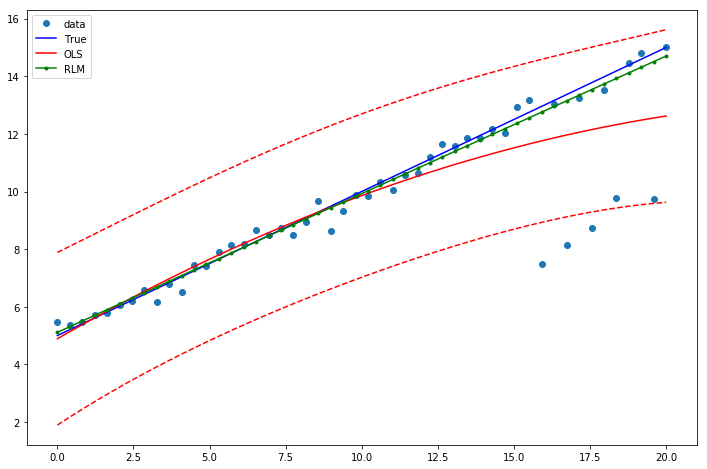

In [10]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, 'o',label="data")
ax.plot(x1, y_true2, 'b-', label="True")
prstd, iv_l, iv_u = wls_prediction_std(res)
ax.plot(x1, res.fittedvalues, 'r-', label="OLS")
ax.plot(x1, iv_u, 'r--')
ax.plot(x1, iv_l, 'r--')
ax.plot(x1, resrlm.fittedvalues, 'g.-', label="RLM")
ax.legend(loc="best")

### Example 2: linear function with linear truth

Fit a new OLS model using only the linear term and the constant:

In [11]:
X2 = X[:,[0,1]]
res2 = sm.OLS(y2, X2).fit()
print(res2.params)
print(res2.bse)

[5.61057499 0.38654649]
[0.39244991 0.03381507]


Estimate RLM:

In [12]:
resrlm2 = sm.RLM(y2, X2).fit()
print(resrlm2.params)
print(resrlm2.bse)

[5.12287374 0.47978435]
[0.10404887 0.00896527]


Draw a plot to compare OLS estimates to the robust estimates:

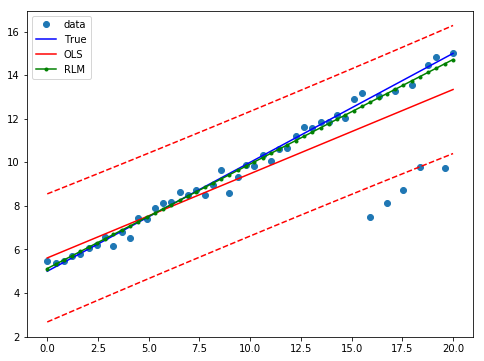

In [13]:
prstd, iv_l, iv_u = wls_prediction_std(res2)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(x1, y2, 'o', label="data")
ax.plot(x1, y_true2, 'b-', label="True")
ax.plot(x1, res2.fittedvalues, 'r-', label="OLS")
ax.plot(x1, iv_u, 'r--')
ax.plot(x1, iv_l, 'r--')
ax.plot(x1, resrlm2.fittedvalues, 'g.-', label="RLM")
legend = ax.legend(loc="best")